### Imports

In [1]:
import warnings
import time
import time
import optuna
import torch
import os
import random
random.seed(3111)
import h5py
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss
from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
from simulai.math.differentiation import CollocationDerivative
from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline
with warnings.catch_warnings():
    from simulai.regression import OpInf
# Adjustment to numpy's error/warning handling for floating point operations
np.seterr(over='raise', invalid='raise');
os.chdir(os.path.split(os.getcwd())[0]) # change directory

c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:33: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:34: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parallel.py:24: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parall

### Read data

In [2]:
with h5py.File(".\\dataset\\OpInfData\\standardData.h5", 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns
  opInfData = np.array(f["standardData"], dtype = np.float32)[:-1]
print(type(opInfData))

<class 'numpy.ndarray'>


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
rom_config = {'n_components': 100} # new number of dimensions
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.02489030733704567
Relative Modal Energy 0.9991121292114258
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (1005, 3362)
projectedData shape: (1005, 100)
reconstructedData shape: (1005, 3362)
Reconstruction MSE = 7.4018e-04


### Data split
90\% used for training, and 10\% for testing

In [5]:
2.5126e-2 - 2.5e-5

0.025101

In [6]:
# timesteps
timeRange = np.arange(0, 2.5101e-2, 2.5e-5)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.9)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (904, 100)
dataTest shape: (101, 100)
dataDerivativeTrain shape: (904, 100)
dataDerivativeTest shape: (101, 100)
timeTrain shape: (904,)
timeTest shape: (101,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [7]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 90, show_progress_bar = True)
# results
print(f"\nBest Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

[I 2023-06-24 11:14:15,251] A new study created in memory with name: no-name-8c985414-7b43-4900-9f4f-7f655344194e
  0%|          | 0/90 [00:00<?, ?it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.41536:   1%|          | 1/90 [00:39<58:33, 39.48s/it]


[I 2023-06-24 11:14:54,728] Trial 0 finished with value: 2.415357791396833 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 1000.0}. Best is trial 0 with value: 2.415357791396833.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Best trial: 0. Best value: 2.41536:   2%|▏         | 2/90 [01:18<57:51, 39.45s/it]


[I 2023-06-24 11:15:34,167] Trial 1 finished with value: 2.32061092044398e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 400.0}. Best is trial 0 with value: 2.415357791396833.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   3%|▎         | 3/90 [01:55<55:22, 38.19s/it]


[I 2023-06-24 11:16:10,852] Trial 2 finished with value: 1.228439717840242 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 300.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   4%|▍         | 4/90 [02:33<54:18, 37.89s/it]


[I 2023-06-24 11:16:48,280] Trial 3 finished with value: 1.3857516192621289 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 350.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   6%|▌         | 5/90 [03:10<53:21, 37.67s/it]


[I 2023-06-24 11:17:25,479] Trial 4 finished with value: 5.959498390082494e+23 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 100.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   7%|▋         | 6/90 [03:47<52:44, 37.67s/it]


[I 2023-06-24 11:18:03,233] Trial 5 finished with value: 3.9685742805857907e+24 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 150.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   8%|▊         | 7/90 [04:23<51:13, 37.03s/it]


[I 2023-06-24 11:18:38,953] Trial 6 finished with value: 1.3857516192621289 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 350.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.22844:   9%|▉         | 8/90 [04:59<50:10, 36.71s/it]


[I 2023-06-24 11:19:14,969] Trial 7 finished with value: 1.6802279226421745e+24 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 50.0}. Best is trial 2 with value: 1.228439717840242.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  10%|█         | 9/90 [05:35<49:08, 36.41s/it]


[I 2023-06-24 11:19:50,708] Trial 8 finished with value: 1.2280947054680709 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 300.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  11%|█         | 10/90 [06:12<48:46, 36.58s/it]


[I 2023-06-24 11:20:27,666] Trial 9 finished with value: 1.1967571300021433e+25 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 200.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  12%|█▏        | 11/90 [06:48<47:49, 36.33s/it]


[I 2023-06-24 11:21:03,434] Trial 10 finished with value: 1.919142342102484 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 450.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  13%|█▎        | 12/90 [07:24<47:17, 36.37s/it]


[I 2023-06-24 11:21:39,911] Trial 11 finished with value: 3.914809436791465e+23 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 100.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  14%|█▍        | 13/90 [08:00<46:30, 36.25s/it]


[I 2023-06-24 11:22:15,861] Trial 12 finished with value: 3.913289561577986e+23 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 100.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  16%|█▌        | 14/90 [08:36<45:41, 36.08s/it]


[I 2023-06-24 11:22:51,550] Trial 13 finished with value: 1.735094469215968 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 500.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  17%|█▋        | 15/90 [09:12<45:06, 36.09s/it]


[I 2023-06-24 11:23:27,668] Trial 14 finished with value: 1.2651161267889744e+24 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 350.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  18%|█▊        | 16/90 [09:48<44:34, 36.15s/it]


[I 2023-06-24 11:24:03,941] Trial 15 finished with value: 1.535528295351354 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 400.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  19%|█▉        | 17/90 [10:25<44:23, 36.48s/it]


[I 2023-06-24 11:24:41,208] Trial 16 finished with value: 2.2359764637138912 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 850.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  20%|██        | 18/90 [11:02<43:48, 36.50s/it]


[I 2023-06-24 11:25:17,764] Trial 17 finished with value: 7.861110193031419e+24 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 200.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  21%|██        | 19/90 [11:37<42:48, 36.18s/it]


[I 2023-06-24 11:25:53,194] Trial 18 finished with value: 1.387068283597455 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 350.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 8. Best value: 1.22809:  22%|██▏       | 20/90 [12:13<42:09, 36.14s/it]


[I 2023-06-24 11:26:29,239] Trial 19 finished with value: 1.6802428477716101e+24 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 50.0}. Best is trial 8 with value: 1.2280947054680709.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  23%|██▎       | 21/90 [12:49<41:19, 35.93s/it]


[I 2023-06-24 11:27:04,689] Trial 20 finished with value: 0.9276347675052815 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 250.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  24%|██▍       | 22/90 [13:25<40:36, 35.83s/it]


[I 2023-06-24 11:27:40,264] Trial 21 finished with value: 1.516156333295866 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 400.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  26%|██▌       | 23/90 [14:01<40:08, 35.94s/it]


[I 2023-06-24 11:28:16,478] Trial 22 finished with value: 3.968900562847063e+24 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 150.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  27%|██▋       | 24/90 [14:37<39:29, 35.91s/it]


[I 2023-06-24 11:28:52,308] Trial 23 finished with value: 1.6802991936477843e+24 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 50.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  28%|██▊       | 25/90 [15:13<39:05, 36.08s/it]


[I 2023-06-24 11:29:28,799] Trial 24 finished with value: 1.8590447198357265e+24 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 50.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  29%|██▉       | 26/90 [15:49<38:17, 35.90s/it]


[I 2023-06-24 11:30:04,263] Trial 25 finished with value: 2.1160011200944897 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 750.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  30%|███       | 27/90 [16:25<37:46, 35.97s/it]


[I 2023-06-24 11:30:40,397] Trial 26 finished with value: 2.1807454373229693 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  31%|███       | 28/90 [17:01<37:24, 36.20s/it]


[I 2023-06-24 11:31:17,138] Trial 27 finished with value: 1.6367663186105065e+24 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 100.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  32%|███▏      | 29/90 [17:39<37:11, 36.58s/it]

[I 2023-06-24 11:31:54,379] Trial 28 finished with value: 3.5877010034808225e+24 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 150.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  33%|███▎      | 30/90 [18:16<36:49, 36.83s/it]


[I 2023-06-24 11:32:32,003] Trial 29 finished with value: 5.307685489348453e+24 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 650.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  34%|███▍      | 31/90 [18:52<36:02, 36.65s/it]


[I 2023-06-24 11:33:08,243] Trial 30 finished with value: 1.8237691529614684 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 550.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  36%|███▌      | 32/90 [19:28<35:11, 36.40s/it]


[I 2023-06-24 11:33:44,054] Trial 31 finished with value: 2.569189004124486 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 1000.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  37%|███▋      | 33/90 [20:04<34:22, 36.19s/it]


[I 2023-06-24 11:34:19,762] Trial 32 finished with value: 1.7324236991917028 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 500.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  38%|███▊      | 34/90 [20:41<33:53, 36.31s/it]


[I 2023-06-24 11:34:56,360] Trial 33 finished with value: 1.5259647851915688e+24 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 50.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  39%|███▉      | 35/90 [21:17<33:20, 36.37s/it]


[I 2023-06-24 11:35:32,855] Trial 34 finished with value: 9.694561758813031e+24 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 200.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  40%|████      | 36/90 [21:52<32:25, 36.04s/it]


[I 2023-06-24 11:36:08,120] Trial 35 finished with value: 1.625566239053781 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  41%|████      | 37/90 [22:28<31:44, 35.94s/it]


[I 2023-06-24 11:36:43,840] Trial 36 finished with value: 1.0848331364416425e+25 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 950.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  42%|████▏     | 38/90 [23:04<31:04, 35.86s/it]


[I 2023-06-24 11:37:19,509] Trial 37 finished with value: 2.2896448712792767 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 900.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  43%|████▎     | 39/90 [23:41<30:45, 36.18s/it]


[I 2023-06-24 11:37:56,446] Trial 38 finished with value: 2.048107500029526 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 650.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  44%|████▍     | 40/90 [24:18<30:18, 36.38s/it]


[I 2023-06-24 11:38:33,269] Trial 39 finished with value: 1.823019816016479 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 550.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  46%|████▌     | 41/90 [24:55<29:54, 36.62s/it]


[I 2023-06-24 11:39:10,451] Trial 40 finished with value: 3.3757389135159768 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 900.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  47%|████▋     | 42/90 [25:32<29:25, 36.78s/it]


[I 2023-06-24 11:39:47,602] Trial 41 finished with value: 3.5877010034808225e+24 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 150.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  48%|████▊     | 43/90 [26:08<28:38, 36.56s/it]


[I 2023-06-24 11:40:23,649] Trial 42 finished with value: 1.8248880296028855 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 550.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  49%|████▉     | 44/90 [26:44<27:51, 36.33s/it]


[I 2023-06-24 11:40:59,439] Trial 43 finished with value: 1.2275262288782194 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 300.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  50%|█████     | 45/90 [27:20<27:16, 36.37s/it]


[I 2023-06-24 11:41:35,892] Trial 44 finished with value: 1.6327992038054793 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  51%|█████     | 46/90 [27:57<26:48, 36.56s/it]


[I 2023-06-24 11:42:12,894] Trial 45 finished with value: 1.8248880296028855 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 550.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  52%|█████▏    | 47/90 [28:34<26:21, 36.77s/it]


[I 2023-06-24 11:42:50,163] Trial 46 finished with value: 1.9787110343656609 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 650.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  53%|█████▎    | 48/90 [29:11<25:46, 36.83s/it]


[I 2023-06-24 11:43:27,117] Trial 47 finished with value: 1.3860930040304766 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 350.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  54%|█████▍    | 49/90 [29:48<25:05, 36.71s/it]


[I 2023-06-24 11:44:03,552] Trial 48 finished with value: 5.929792668108978e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 750.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  56%|█████▌    | 50/90 [30:24<24:23, 36.59s/it]


[I 2023-06-24 11:44:39,862] Trial 49 finished with value: 2.3217492426103665 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 750.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  57%|█████▋    | 51/90 [31:02<24:00, 36.94s/it]


[I 2023-06-24 11:45:17,623] Trial 50 finished with value: 5.4130245668447207e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 550.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  58%|█████▊    | 52/90 [31:38<23:19, 36.84s/it]


[I 2023-06-24 11:45:54,233] Trial 51 finished with value: 2.3664028113348032 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 900.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  59%|█████▉    | 53/90 [32:16<22:50, 37.03s/it]


[I 2023-06-24 11:46:31,720] Trial 52 finished with value: 8.261918720279839e+24 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 150.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  60%|██████    | 54/90 [32:53<22:18, 37.17s/it]

[I 2023-06-24 11:47:09,006] Trial 53 finished with value: 2.32061092044398e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 400.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  61%|██████    | 55/90 [33:30<21:31, 36.89s/it]


[I 2023-06-24 11:47:45,446] Trial 54 finished with value: 2.1733446937856615 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  62%|██████▏   | 56/90 [34:05<20:39, 36.45s/it]


[I 2023-06-24 11:48:20,877] Trial 55 finished with value: 2.3468675869278863 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 950.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  63%|██████▎   | 57/90 [34:41<19:57, 36.29s/it]


[I 2023-06-24 11:48:56,797] Trial 56 finished with value: 1.6256576966298444 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  64%|██████▍   | 58/90 [35:18<19:28, 36.51s/it]


[I 2023-06-24 11:49:33,823] Trial 57 finished with value: 1.510744998810099 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 400.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  66%|██████▌   | 59/90 [35:55<18:55, 36.62s/it]


[I 2023-06-24 11:50:10,705] Trial 58 finished with value: 1.5116305261136966 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 400.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  67%|██████▋   | 60/90 [36:31<18:15, 36.50s/it]


[I 2023-06-24 11:50:46,928] Trial 59 finished with value: 2.1909900474873383 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  68%|██████▊   | 61/90 [37:07<17:29, 36.18s/it]


[I 2023-06-24 11:51:22,351] Trial 60 finished with value: 2.2352306846772088 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 850.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  69%|██████▉   | 62/90 [37:42<16:50, 36.08s/it]


[I 2023-06-24 11:51:58,190] Trial 61 finished with value: 1.2273322549335406 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 300.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  70%|███████   | 63/90 [38:18<16:11, 35.98s/it]


[I 2023-06-24 11:52:33,936] Trial 62 finished with value: 1.919142342102484 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  71%|███████   | 64/90 [38:54<15:30, 35.79s/it]


[I 2023-06-24 11:53:09,272] Trial 63 finished with value: 0.9287012162423203 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 250.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  72%|███████▏  | 65/90 [39:29<14:52, 35.69s/it]


[I 2023-06-24 11:53:44,742] Trial 64 finished with value: 1.2270866951079564 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 300.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  73%|███████▎  | 66/90 [40:06<14:22, 35.94s/it]


[I 2023-06-24 11:54:21,260] Trial 65 finished with value: 2.4267394210561712 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 900.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  74%|███████▍  | 67/90 [40:41<13:46, 35.93s/it]


[I 2023-06-24 11:54:57,171] Trial 66 finished with value: 1.9869582229065184 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 650.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  76%|███████▌  | 68/90 [41:17<13:07, 35.79s/it]


[I 2023-06-24 11:55:32,621] Trial 67 finished with value: 0.9277304634429417 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 250.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  77%|███████▋  | 69/90 [41:52<12:30, 35.72s/it]


[I 2023-06-24 11:56:08,184] Trial 68 finished with value: 4.292007026868967e+24 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 150.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  78%|███████▊  | 70/90 [42:27<11:49, 35.49s/it]


[I 2023-06-24 11:56:43,123] Trial 69 finished with value: 2.232162466302612 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  79%|███████▉  | 71/90 [43:03<11:13, 35.44s/it]


[I 2023-06-24 11:57:18,467] Trial 70 finished with value: 6846503170460.894 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 0.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  80%|████████  | 72/90 [43:38<10:36, 35.34s/it]


[I 2023-06-24 11:57:53,550] Trial 71 finished with value: 1.3862084534343115 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 350.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  81%|████████  | 73/90 [44:13<09:58, 35.20s/it]


[I 2023-06-24 11:58:28,449] Trial 72 finished with value: 1.6306670702148065 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  82%|████████▏ | 74/90 [44:48<09:25, 35.32s/it]


[I 2023-06-24 11:59:04,056] Trial 73 finished with value: 1.9315161470129762e+22 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 200.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  83%|████████▎ | 75/90 [45:24<08:51, 35.40s/it]


[I 2023-06-24 11:59:39,633] Trial 74 finished with value: 3.914809436791465e+23 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 100.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  84%|████████▍ | 76/90 [45:59<08:13, 35.28s/it]


[I 2023-06-24 12:00:14,623] Trial 75 finished with value: 2.380492730005441 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 950.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  86%|████████▌ | 77/90 [46:34<07:39, 35.36s/it]


[I 2023-06-24 12:00:50,179] Trial 76 finished with value: 2.393292119953307 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 1000.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  87%|████████▋ | 78/90 [47:10<07:06, 35.53s/it]


[I 2023-06-24 12:01:26,106] Trial 77 finished with value: 2.046833475735565 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 700.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  88%|████████▊ | 79/90 [47:47<06:34, 35.89s/it]


[I 2023-06-24 12:02:02,842] Trial 78 finished with value: 2.3577010252732853 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 950.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  89%|████████▉ | 80/90 [48:23<05:59, 35.93s/it]


[I 2023-06-24 12:02:38,857] Trial 79 finished with value: 0.9276347675052815 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 250.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  90%|█████████ | 81/90 [49:00<05:27, 36.35s/it]


[I 2023-06-24 12:03:16,203] Trial 80 finished with value: 1.5104302287386433 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 400.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  91%|█████████ | 82/90 [49:36<04:47, 35.99s/it]


[I 2023-06-24 12:03:51,340] Trial 81 finished with value: 2.279306538152208 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  92%|█████████▏| 83/90 [50:11<04:11, 35.94s/it]


[I 2023-06-24 12:04:27,176] Trial 82 finished with value: 2.1790343073023504 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  93%|█████████▎| 84/90 [50:47<03:34, 35.80s/it]


[I 2023-06-24 12:05:02,633] Trial 83 finished with value: 1.6306670702148065 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 450.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  94%|█████████▍| 85/90 [51:22<02:58, 35.71s/it]


[I 2023-06-24 12:05:38,150] Trial 84 finished with value: 7.857027628130331e+24 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 200.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  96%|█████████▌| 86/90 [51:59<02:23, 35.86s/it]


[I 2023-06-24 12:06:14,348] Trial 85 finished with value: 1.0848331364416425e+25 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 950.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  97%|█████████▋| 87/90 [52:35<01:47, 35.90s/it]


[I 2023-06-24 12:06:50,342] Trial 86 finished with value: 5.759786924568988e+24 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 1000.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  98%|█████████▊| 88/90 [53:10<01:11, 35.88s/it]


[I 2023-06-24 12:07:26,164] Trial 87 finished with value: 1.4749960891028448e+25 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 200.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635:  99%|█████████▉| 89/90 [53:46<00:35, 35.79s/it]


[I 2023-06-24 12:08:01,740] Trial 88 finished with value: 3.075065197989201 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 800.0}. Best is trial 20 with value: 0.9276347675052815.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 20. Best value: 0.927635: 100%|██████████| 90/90 [54:22<00:00, 36.25s/it]


[I 2023-06-24 12:08:37,739] Trial 89 finished with value: 3.913390505809895e+23 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 100.0}. Best is trial 20 with value: 0.9276347675052815.

Best Parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 250.0}
Best objective value: 0.9276347675052815


Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h, 90 trials each). Random sampler achieved the smallest test interval.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [17]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    lambda_linear = study.best_params["lambdaLinear"],
    lambda_quadratic = study.best_params["lambdaQuad"]
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [18]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (101, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (101, 3362)


### Model error

In [19]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 9.2763e-01
Full order MSE = 2.9219e-02


### Integration error history
Sample some positions and plot their time integration error histories

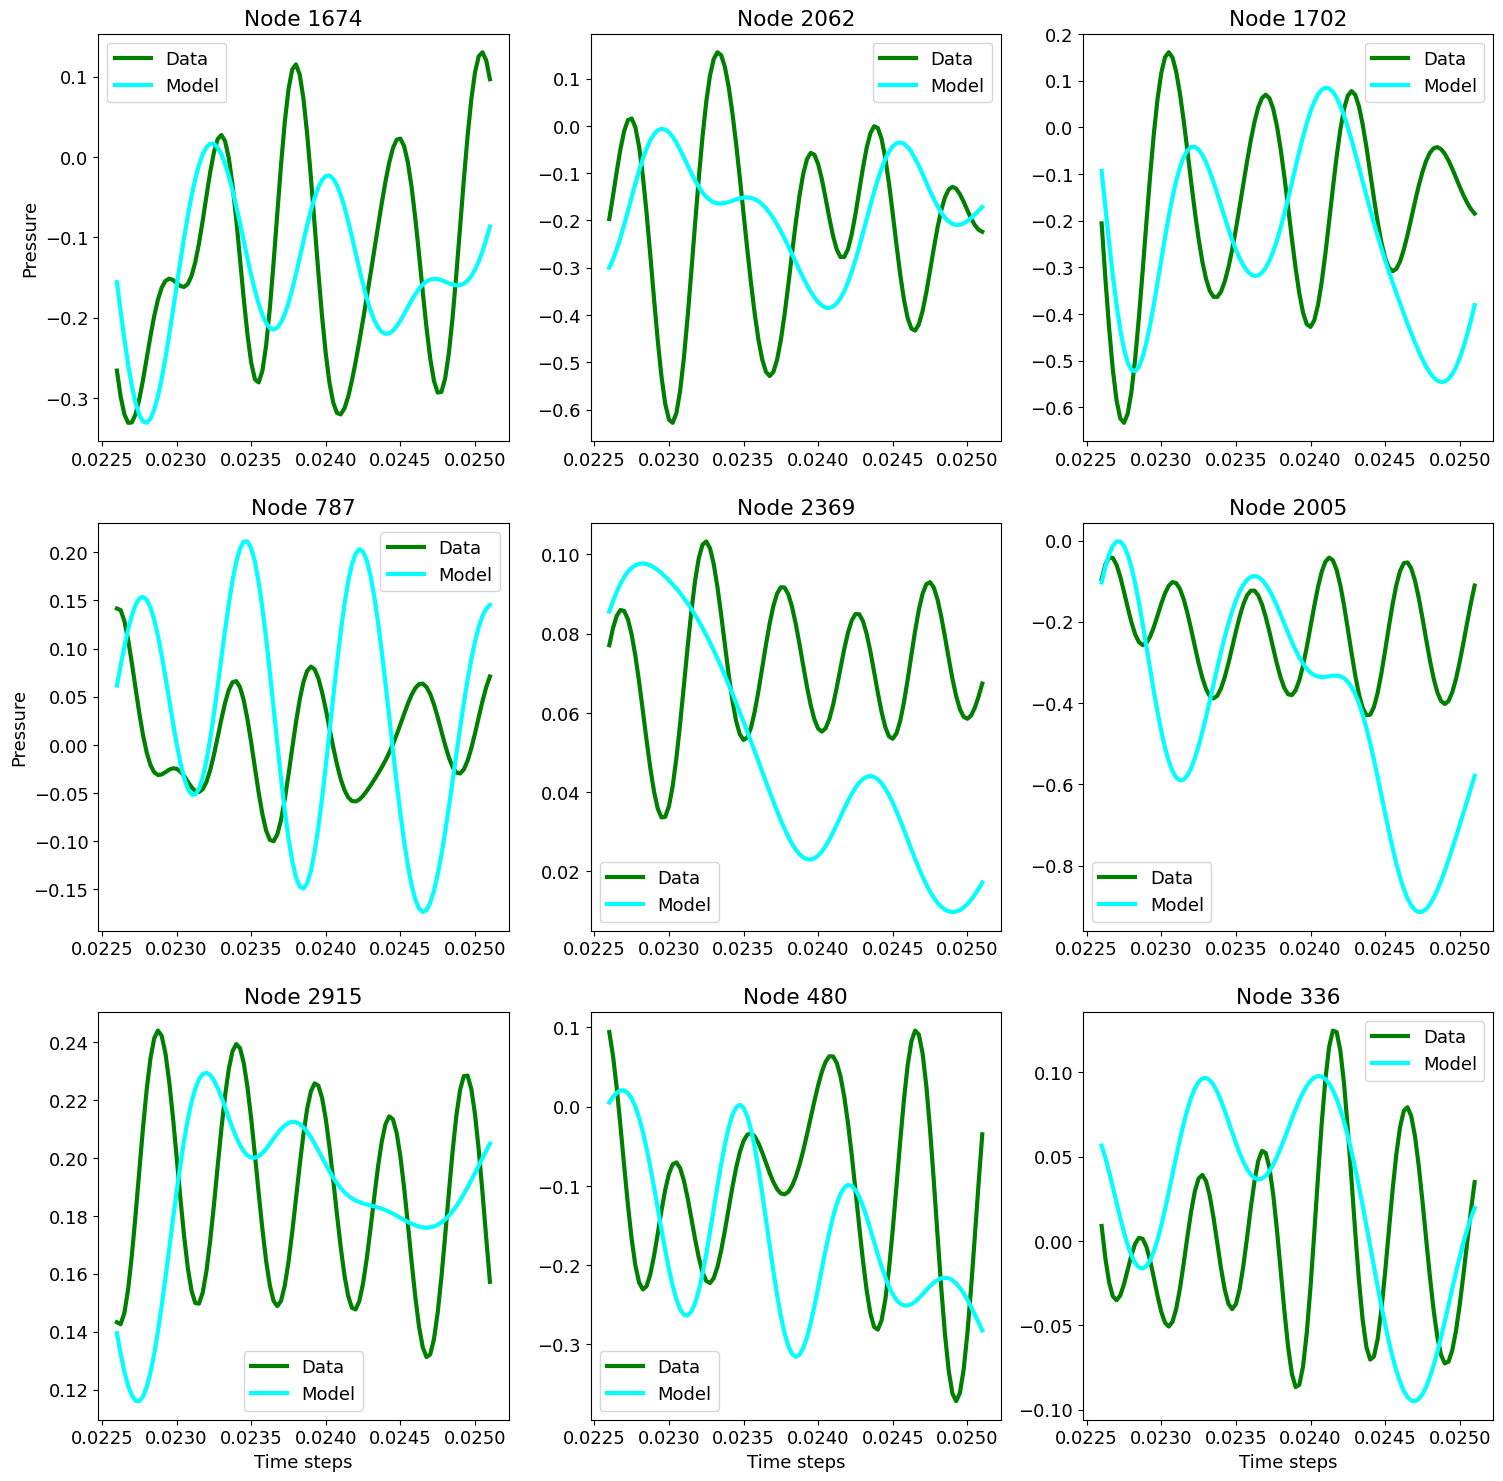

In [20]:
plt.rcParams['font.size'] = 13
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Reconstruction error
Sample some points and plot their reconstruction error histories in the train split

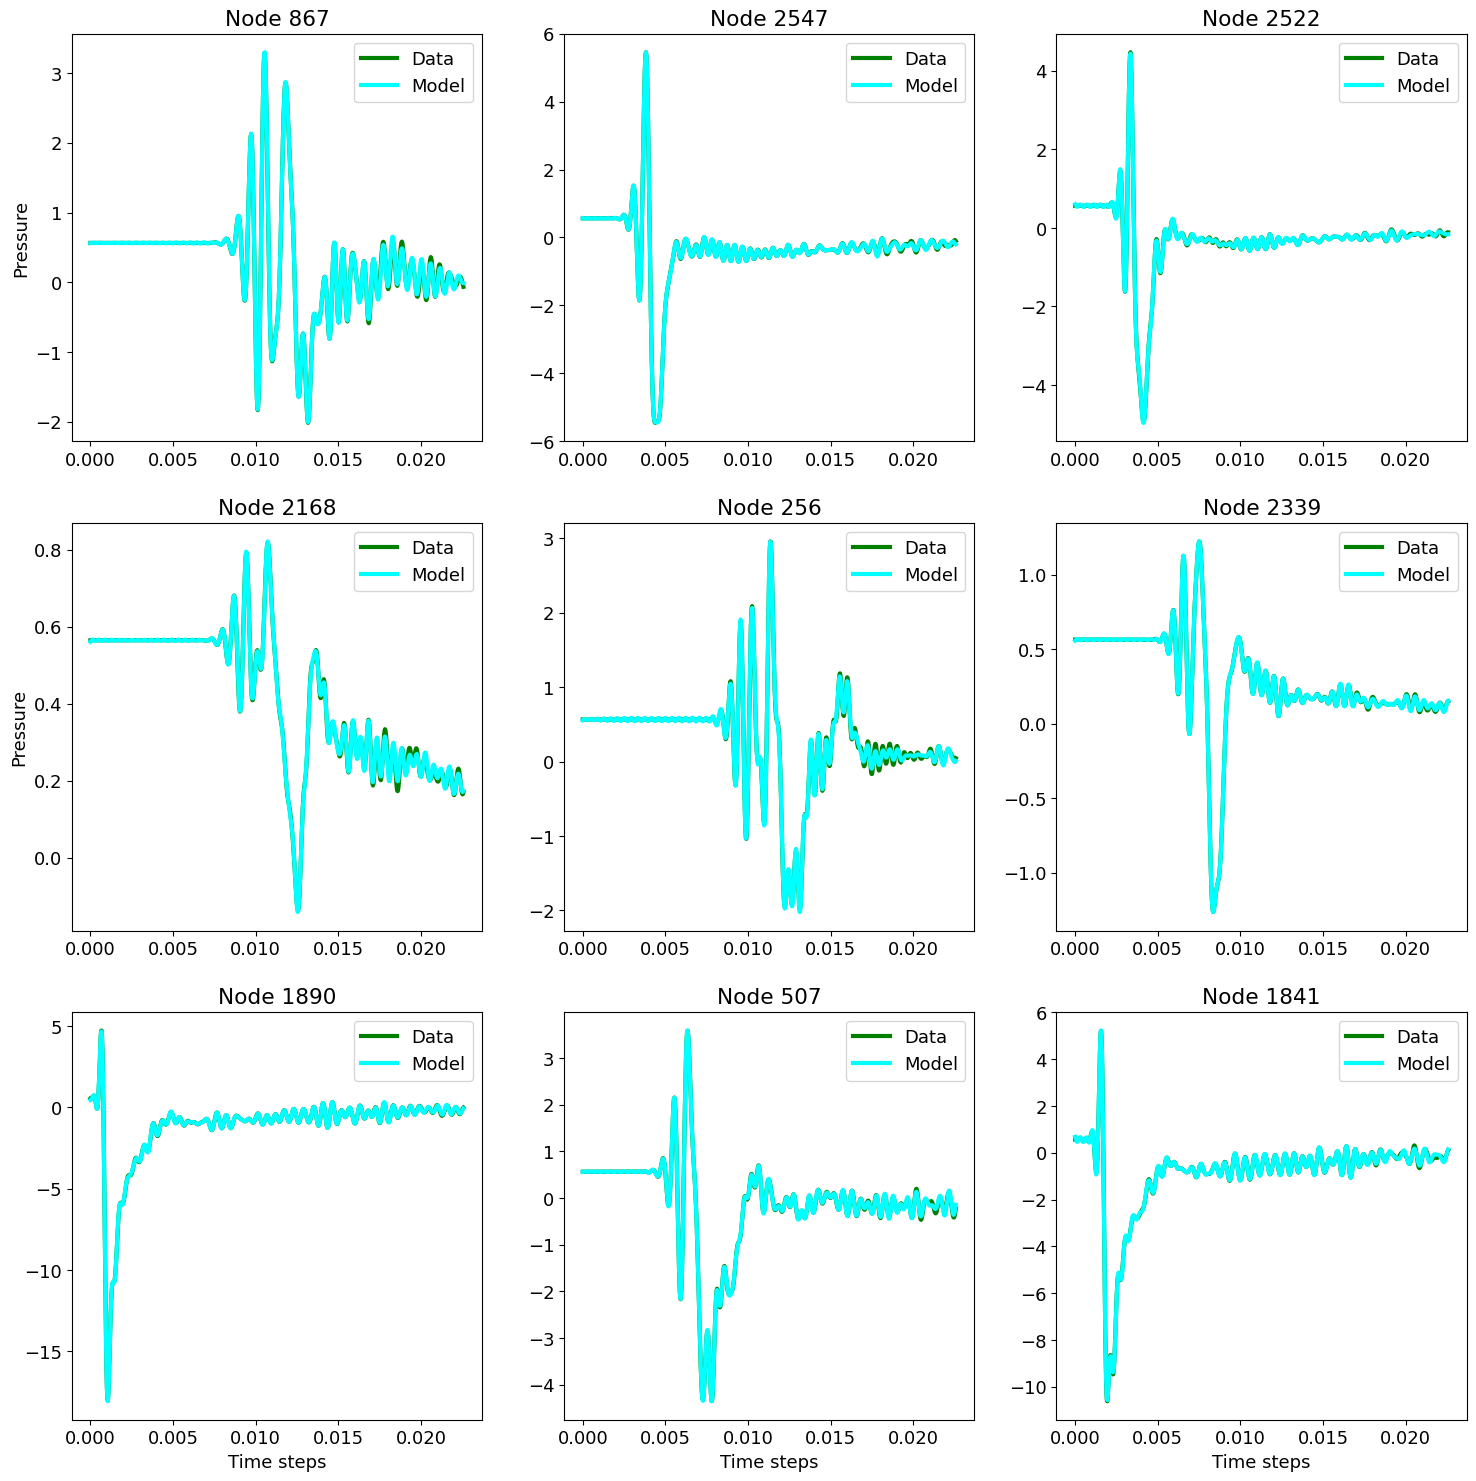

In [21]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTrain, opInfData[:timeTrain.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTrain, reconstructedData[:timeTrain.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")